In [1]:
import ROOT as rt
import array as array
import os
import glob
from random import gauss
import numpy as np
import root_numpy as rtnpy
import pandas as pd
import h5py
from awkward import JaggedArray, Table
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,'/t3home/gelliu/Unfolding_Substructure/CMSSW_10_6_5/python/jetObservables/Unfolding')
import CMS_lumi,tdrstyle
tdrstyle.setTDRStyle()
rt.gROOT.SetBatch()
rt.gROOT.ForceStyle()
rt.gStyle.SetOptStat(0)

Welcome to JupyROOT 6.14/09


In [2]:
lumi=5750+2573+4242+4025+3104+7576+8632
print lumi
CrossSection=np.array([1973000000,117200,7760,642.1,185.9,32.05,9.365,0.8398,0.1124,0.006752,0.0001626])
EventNumber=np.array([3520.33,6875125,4150588,9344512.12,6571952,8456672.59,6680029,831433,692968,834414,11166471])
Scale=lumi*CrossSection/EventNumber
print Scale
MC_Compo=np.array(['QCD Flat','QCD Pt170to300','QCD Pt300to470','QCD Pt470to600','QCD Pt600to800','QCD Pt800to1000','QCD Pt1000to1400','QCD Pt1400to1800','QCD Pt1800to2400','QCD Pt2400to3200','QCD Pt3200toInf'])

35902
[2.01215926e+10 6.12020058e+02 6.71229040e+01 2.46697462e+00
 1.01555547e+00 1.36065230e-01 5.03324507e-02 3.62632943e-02
 5.82333499e-03 2.90515624e-04 5.22785149e-07]


In [3]:
fData=[]
path='/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_JetHTRun2016*.root'
files=glob.glob(path)
for f in files:
    fData.append(f)
print len(fData)
fMC=[
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt-15to7000_TuneCUETP8M1_FlatP6_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_170to300_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_300to470_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_470to600_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_600to800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_800to1000_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1000to1400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1400to1800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1800to2400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_2400to3200_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_3200toInf_TuneCUETP8M1_13TeV_pythia8.root'
    ]

print len(fMC)

7
11


# Functions to refill histograms with new bins

In [4]:
def Fill1D(h0,h,bins):
    N=h0.GetNbinsX()
    content=np.zeros((len(bins)-1),dtype=float)
    for i in range(len(bins)-1):
        content[i]=0
    for i in range(N):
        center=h0.GetBinCenter(i+1)
        index=np.digitize(np.array([center]),bins)
        if index[0] < len(bins):
            content[index[0]-1]+=h0.GetBinContent(i+1)
    for i in range(len(bins)-1):
        h.SetBinContent(i+1,content[i])

def Fill2D(h0,h,binx,biny):
    Nx=h0.GetNbinsX()
    Ny=h0.GetNbinsY()
    hx=h0.ProjectionX()
    hy=h0.ProjectionY()
    content=np.zeros((len(binx)-1,len(biny)-1),dtype=float)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            content[i][j]=0
    for i in range(Nx):
        for j in range(Ny):
            centerx=hx.GetBinCenter(i+1)
            indexx=np.digitize(np.array([centerx]),binx)
            centery=hy.GetBinCenter(j+1)
            indexy=np.digitize(np.array([centery]),biny)
            if indexx[0] < len(binx) and indexy[0] < len(biny):
                content[indexx[0]-1][indexy[0]-1]+=h0.GetBinContent(i+1,j+1)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            h.SetBinContent(i+1,j+1,content[i][j])

# Do unfolding

In [23]:
def DoUnfolding(Response,Data_reco,MC_reco,MC_gen,SysUnc,tau):
    
    tunfolder = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolder.SetInput(Data_reco)
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            tunfolder.AddSysError(SysUnc[source+ud],source+ud,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfoldSys.kSysErrModeMatrix)
    tunfolder.DoUnfold(0.)
    Data_unfolded_TotalUnc=tunfolder.GetOutput("Data_unfolded_TotalUnc")
    Data_folded=tunfolder.GetFoldedOutput("Data_folded")
    Data_unfolded_StatUnfUnc=Data_unfolded_TotalUnc.Clone("Data_unfolded_StatUnfUnc")
    Unc_unfolded_Total=Data_unfolded_TotalUnc.Clone("Total Uncertainties")
    Unc_unfolded_Total.Reset()
    Unc_unfolded_Sys=Data_unfolded_TotalUnc.Clone("Systematic Uncertainties")
    Unc_unfolded_Sys.Reset()
    Unc_unfolded_SysSeries={}
    
    cov_total=tunfolder.GetEmatrixTotal("Total Covariance Matrix")
    
    N=Data_unfolded_TotalUnc.GetNbinsX()

    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            Unc_unfolded_SysSeries[source+ud]=tunfolder.GetDeltaSysSource(source+ud, "Systematic Uncertainties:"+source+ud, "-1#sigma")
        Unc_unfolded_SysSeries[source+"Total"]=Unc_unfolded_SysSeries[source+"Up"].Clone("Systematic Uncertainties:"+source+"Total")
        Unc_unfolded_SysSeries[source+"Total"].Reset()
        for i in range(1,N+1):
            sys1=Unc_unfolded_SysSeries[source+"Up"].GetBinContent(i)
            sys2=Unc_unfolded_SysSeries[source+"Down"].GetBinContent(i)
            Unc_unfolded_SysSeries[source+"Total"].SetBinContent(i,np.sqrt(sys1**2+sys2**2))
        Unc_unfolded_Sys.Add(Unc_unfolded_SysSeries[source+"Total"])
        
    for i in range(1,N+1):
        stat=cov_total.GetBinContent(i,i)
        sys=Unc_unfolded_Sys.GetBinContent(i)
        total=np.sqrt(stat+sys**2)
        Data_unfolded_StatUnfUnc.SetBinError(i,np.sqrt(stat))
        Data_unfolded_TotalUnc.SetBinError(i,total)
        Unc_unfolded_Total.SetBinContent(i,total)
    
    
    rt.tdrStyle.SetPadRightMargin(0.05)
    rt.tdrStyle.SetPadLeftMargin(0.15)
    can = rt.TCanvas('can', 'can',  10, 10, 750, 750 )
    pad1 = rt.TPad("pad1", "Main",0,0.207,1.00,1.00,-1)
    pad2 = rt.TPad("pad2", "Ratio",0,0.00,1.00,0.30,-1);
    pad1.Draw()
    pad2.Draw()

    pad1.cd()

    legend=rt.TLegend(0.53,0.42,0.90,0.88)
    legend.SetFillStyle(0)
    #legend.SetTextSize(0.03)
    
    MC_gen.Scale(1,"width")
    MC_gen.SetLineWidth(2)
    MC_gen.SetLineColor(1)
    legend.AddEntry(MC_gen,"Gen-level MC","l")
    
    Data_unfolded_StatUnfUnc.Scale(1,"width")
    Data_unfolded_StatUnfUnc.SetMarkerStyle(0)
    Data_unfolded_StatUnfUnc.SetMarkerColor(rt.kRed)
    Data_unfolded_StatUnfUnc.SetLineColor(rt.kRed-3)
    Data_unfolded_StatUnfUnc.SetLineWidth(2)
    legend.AddEntry(Data_unfolded_StatUnfUnc,"Unfolded, stat+unf unc","l")
    
    Data_unfolded_TotalUnc.Scale(1,"width")
    Data_unfolded_TotalUnc.SetMarkerStyle(4)
    Data_unfolded_TotalUnc.SetMarkerSize(2)
    Data_unfolded_TotalUnc.SetMarkerColor(rt.kRed)
    Data_unfolded_TotalUnc.SetLineColor(rt.kRed)
    legend.AddEntry(Data_unfolded_TotalUnc,"Unfolded, total unc","pl")
    
    Data_folded.Rebin(2)
    Data_folded.Scale(1,"width")
    Data_folded.SetLineWidth(2)
    Data_folded.SetLineStyle(2)
    Data_folded.SetLineColor(8)
    legend.AddEntry(Data_folded,"Folded","l")
    
    MC_reco.Rebin(2)
    MC_reco.Scale(1,"width")
    MC_reco.SetLineWidth(2)
    MC_reco.SetLineStyle(2)
    MC_reco.SetLineColor(rt.kBlue)
    legend.AddEntry(MC_reco,"Reco-level MC","l")
    
    Data_reco.Rebin(2)
    Data_reco.Scale(1,"width")
    Data_reco.SetLineWidth(2)
    Data_reco.SetLineStyle(2)
    Data_reco.SetLineColor(rt.kMagenta)
    legend.AddEntry(Data_reco,"Data","l")
    
    MC_gen.GetYaxis().SetTitle( '#frac{1}{d#sigma}#frac{d#sigma}{d('+tau+')}' )
    MC_gen.GetYaxis().SetTitleOffset(0.95)
    MC_gen.SetMaximum(1.2*max([MC_gen.GetMaximum(),Data_unfolded_StatUnfUnc.GetMaximum(),Data_folded.GetMaximum(),MC_reco.GetMaximum(),Data_reco.GetMaximum()]))
    
    MC_gen.Draw("histe")
    Data_unfolded_StatUnfUnc.Draw("same")
    Data_unfolded_TotalUnc.Draw("e1 same")
    Data_folded.Draw("hist same")
    Data_reco.Draw("hist same")
    MC_reco.Draw("hist same")
    
    legend.Draw()
    
    CMS_lumi.extraText="Preliminary"
    CMS_lumi.lumi_13TeV=str(round((lumi/1000.),2))+" fb^{-1}, 2016 (13 TeV)"
    CMS_lumi.relPosX=0.13
    CMS_lumi.CMS_lumi(pad1,4,0)
    
    pad2.cd()
    rt.gStyle.SetOptFit(1)
    pad2.SetGrid()
    pad2.SetTopMargin(0)
    pad2.SetBottomMargin(0.3)
    #tmpPad2= pad2.DrawFrame( 0, 0.5, 1, 1.5 )
    #tmpPad2.GetXaxis().SetTitle(tau)
    #tmpPad2.GetYaxis().SetTitle("#frac{MC-Truth}{Unfolded}")
    #tmpPad2.GetYaxis().SetTitleOffset(0.5)
    #tmpPad2.GetYaxis().SetRangeUser(0,2)
    #tmpPad2.GetYaxis().CenterTitle()
    #tmpPad2.SetLabelSize(0.12, 'x')
    #tmpPad2.SetTitleSize(0.12, 'x')
    #tmpPad2.SetLabelSize(0.12, 'y')
    #tmpPad2.SetTitleSize(0.12, 'y')
    #tmpPad2.SetNdivisions(505, 'x')
    #tmpPad2.SetNdivisions(505, 'y')
    #pad2.Modified()
    #hRatioUp=rt.TGraphAsymmErrors()
    #hRatioUp.Divide(MC_gen,Data_unfolded_TotalUnc,"pois")
    hRatioUp=MC_gen.Clone("Ratio")
    hRatioUp.Divide(Data_unfolded_TotalUnc)
    hRatioUp.GetXaxis().SetTitle(tau)
    hRatioUp.GetXaxis().SetTitleSize(0.12)
    hRatioUp.GetXaxis().SetLabelSize(0.12)
    hRatioUp.GetXaxis().SetNdivisions(505)
    hRatioUp.GetYaxis().SetTitle("#frac{MC-Truth}{Unfolded}")
    hRatioUp.GetYaxis().SetRangeUser(0,2)
    hRatioUp.GetYaxis().CenterTitle()
    hRatioUp.GetYaxis().SetTitleSize(0.12)
    hRatioUp.GetYaxis().SetLabelSize(0.12)
    hRatioUp.GetYaxis().SetNdivisions(505)
    hRatioUp.GetYaxis().SetTitleOffset(0.5)
    hRatioUp.SetMarkerStyle(8)
    hRatioUp.Draw('P0')
    
    can.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/Unfolding/QCD_pythia8_ptbinned_dijetSel/'+tau+'.png')
    
    
    canUnc=rt.TCanvas('canUnc','canUnc',10,10,750,500)
    canUnc.SetLogy()
    legendUnc=rt.TLegend(0.70,0.55,0.90,0.88)
    if tau=='#tau_{1}^{(0.5)}' or tau=='#tau_{1}^{(2)}':
        print "yes"
        legendUnc=rt.TLegend(0.2,0.2,0.4,0.5)
    legendUnc.SetFillStyle(0)
    #legendUnc.SetTextSize(0.03)
    
    #Unc_unfolded_Total.Scale(1./Unc_unfolded_Total.Integral())
    Unc_unfolded_Total.GetXaxis().SetTitle(tau)
    Unc_unfolded_Total.GetYaxis().SetTitle('Fractional Uncertainty')
    Unc_unfolded_Total.SetMaximum(Unc_unfolded_Total.GetMaximum()*1.2)
    Unc_unfolded_Total.SetMinimum(min([Unc_unfolded_SysSeries["jesTotalTotal"].GetMinimum()*0.8,Unc_unfolded_SysSeries["jerTotal"].GetMinimum()*0.8,Unc_unfolded_SysSeries["puTotal"].GetMinimum()*0.8]))
    Unc_unfolded_Total.SetLineWidth(2)
    Unc_unfolded_Total.Draw("hist")
    legendUnc.AddEntry(Unc_unfolded_Total, 'Total Unc', 'l')
    
    #Unc_unfolded_Sys.Scale(1./Unc_unfolded_Total.Integral())
    Unc_unfolded_Sys.SetLineWidth(2)
    Unc_unfolded_Sys.SetLineStyle(2)
    Unc_unfolded_Sys.Draw("hist same")
    legendUnc.AddEntry(Unc_unfolded_Sys,'Total Syst Unc',"l")
    
    dummy=2
    for source in ['jesTotal',"jer","pu"]:
        Unc_unfolded_SysSeries[source+"Total"].SetLineColor(dummy)
        Unc_unfolded_SysSeries[source+"Total"].SetLineWidth(2)
        Unc_unfolded_SysSeries[source+"Total"].SetLineStyle(3)
        #Unc_unfolded_SysSeries[source+"Total"].Scale(1./Unc_unfolded_Total.Integral())
        Unc_unfolded_SysSeries[source+"Total"].Draw("hist same")
        legendUnc.AddEntry(Unc_unfolded_SysSeries[source+"Total"],source+' Total','l')
        dummy+=1
    
    legendUnc.Draw()
    
    CMS_lumi.CMS_lumi(canUnc,4,0)
    
    canUnc.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/Unfolding/QCD_pythia8_ptbinned_dijetSel/'+tau+'_Unc.png')
    
    return can,canUnc

# Variables

In [6]:
variables=['tau_0p5_0','tau_1_0','tau_2_0','tau_0p5_1','tau_1_1','tau_2_1','tau_0p5_2','tau_1_2','tau_2_2','tau_0p5_3','tau_1_3','tau_2_3']
reco={}
gen={}
resp={}
sysunc={}
title={}
for var in variables:
    reco[var]='recoJet_'+var+'_nom_dijetSel'
    gen[var]='genJet_'+var+'_dijetSel'
    resp[var]='respJet_'+var+'_nom_dijetSel'
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            sysunc[var+source+ud]='respJet_'+var+'_'+source+ud+'_dijetSel'
    title[var]='#tau_{'+str(int(var.split('_')[2])+1)+'}^{'+('(0.5)' if 'p' in var.split('_')[1] else '('+var.split('_')[1]+')')+'}'
print title

{'tau_1_0': '#tau_{1}^{(1)}', 'tau_1_1': '#tau_{2}^{(1)}', 'tau_1_2': '#tau_{3}^{(1)}', 'tau_1_3': '#tau_{4}^{(1)}', 'tau_2_3': '#tau_{4}^{(2)}', 'tau_2_2': '#tau_{3}^{(2)}', 'tau_2_1': '#tau_{2}^{(2)}', 'tau_2_0': '#tau_{1}^{(2)}', 'tau_0p5_2': '#tau_{3}^{(0.5)}', 'tau_0p5_3': '#tau_{4}^{(0.5)}', 'tau_0p5_0': '#tau_{1}^{(0.5)}', 'tau_0p5_1': '#tau_{2}^{(0.5)}'}


In [7]:
Data_0={}
MC1_0={}
MC2_0={}
for var in variables:
    Data_0[reco[var]]=rt.TH1D("Data_reco0:"+title[var],"Data_reco0:"+title[var]+';'+title[var]+';Events/0.01',100,0,1)
    MC1_0[reco[var]]=rt.TH1D("MC1_reco0:"+title[var],"MC1_reco0:"+title[var]+';'+title[var]+';Events/0.01',100,0,1)
    MC1_0[gen[var]]=rt.TH1D("MC1_gen0:"+title[var],"MC1_gen0:"+title[var]+';'+title[var]+';Events/0.01',100,0,1)
    MC1_0[resp[var]]=rt.TH2D("Response1_0:"+title[var],"Response1_0:"+title[var]+';'+title[var]+' gen;'+title[var]+' reco',100,0,1,100,0,1)
    MC2_0[reco[var]]=rt.TH1D("MC2_reco0:"+title[var],"MC2_reco0:"+title[var]+';'+title[var]+';Events/0.01',100,0,1)
    MC2_0[gen[var]]=rt.TH1D("MC2_gen0:"+title[var],"MC2_gen0:"+title[var]+';'+title[var]+';Events/0.01',100,0,1)
    MC2_0[resp[var]]=rt.TH2D("Response2_0:"+title[var],"Response2_0:"+title[var]+';'+title[var]+' gen;'+title[var]+' reco',100,0,1,100,0,1)
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            MC1_0[sysunc[var+source+ud]]=rt.TH2D('Unc1_0_'+title[var]+':'+source+ud,'Unc1_0_'+title[var]+':'+source+ud+';'+title[var]+' gen;'+title[var]+' reco',100,0,1,100,0,1)
            MC2_0[sysunc[var+source+ud]]=rt.TH2D('Unc2_0_'+title[var]+':'+source+ud,'Unc2_0_'+title[var]+':'+source+ud+';'+title[var]+' gen;'+title[var]+' reco',100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    for var in variables:
        Data_0[reco[var]].Add(t.Get(reco[var]))
    f_Data[i].Close()
    
f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
#MC1_reco0.Add(t.Get(reco),Scale[i])
#MC1_gen0.Add(t.Get(gen),Scale[i])
for var in variables:
    MC1_0[reco[var]].Add(t.Get(resp[var]).ProjectionY(),Scale[i])
    MC1_0[gen[var]].Add(t.Get(resp[var]).ProjectionX(),Scale[i])
    MC1_0[resp[var]].Add(t.Get(resp[var]),Scale[i])
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            MC1_0[sysunc[var+source+ud]].Add(t.Get(sysunc[var+source+ud]),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    #MC2_reco0.Add(t.Get(reco),Scale[i])
    #MC2_gen0.Add(t.Get(gen),Scale[i])
    for var in variables:
        MC2_0[reco[var]].Add(t.Get(resp[var]).ProjectionY(),Scale[i])
        MC2_0[gen[var]].Add(t.Get(resp[var]).ProjectionX(),Scale[i])
        MC2_0[resp[var]].Add(t.Get(resp[var]),Scale[i])
        for source in ['jesTotal',"jer","pu"]:
            for ud in ['Up','Down']:
                MC2_0[sysunc[var+source+ud]].Add(t.Get(sysunc[var+source+ud]),Scale[i])
    f_MC[i].Close()

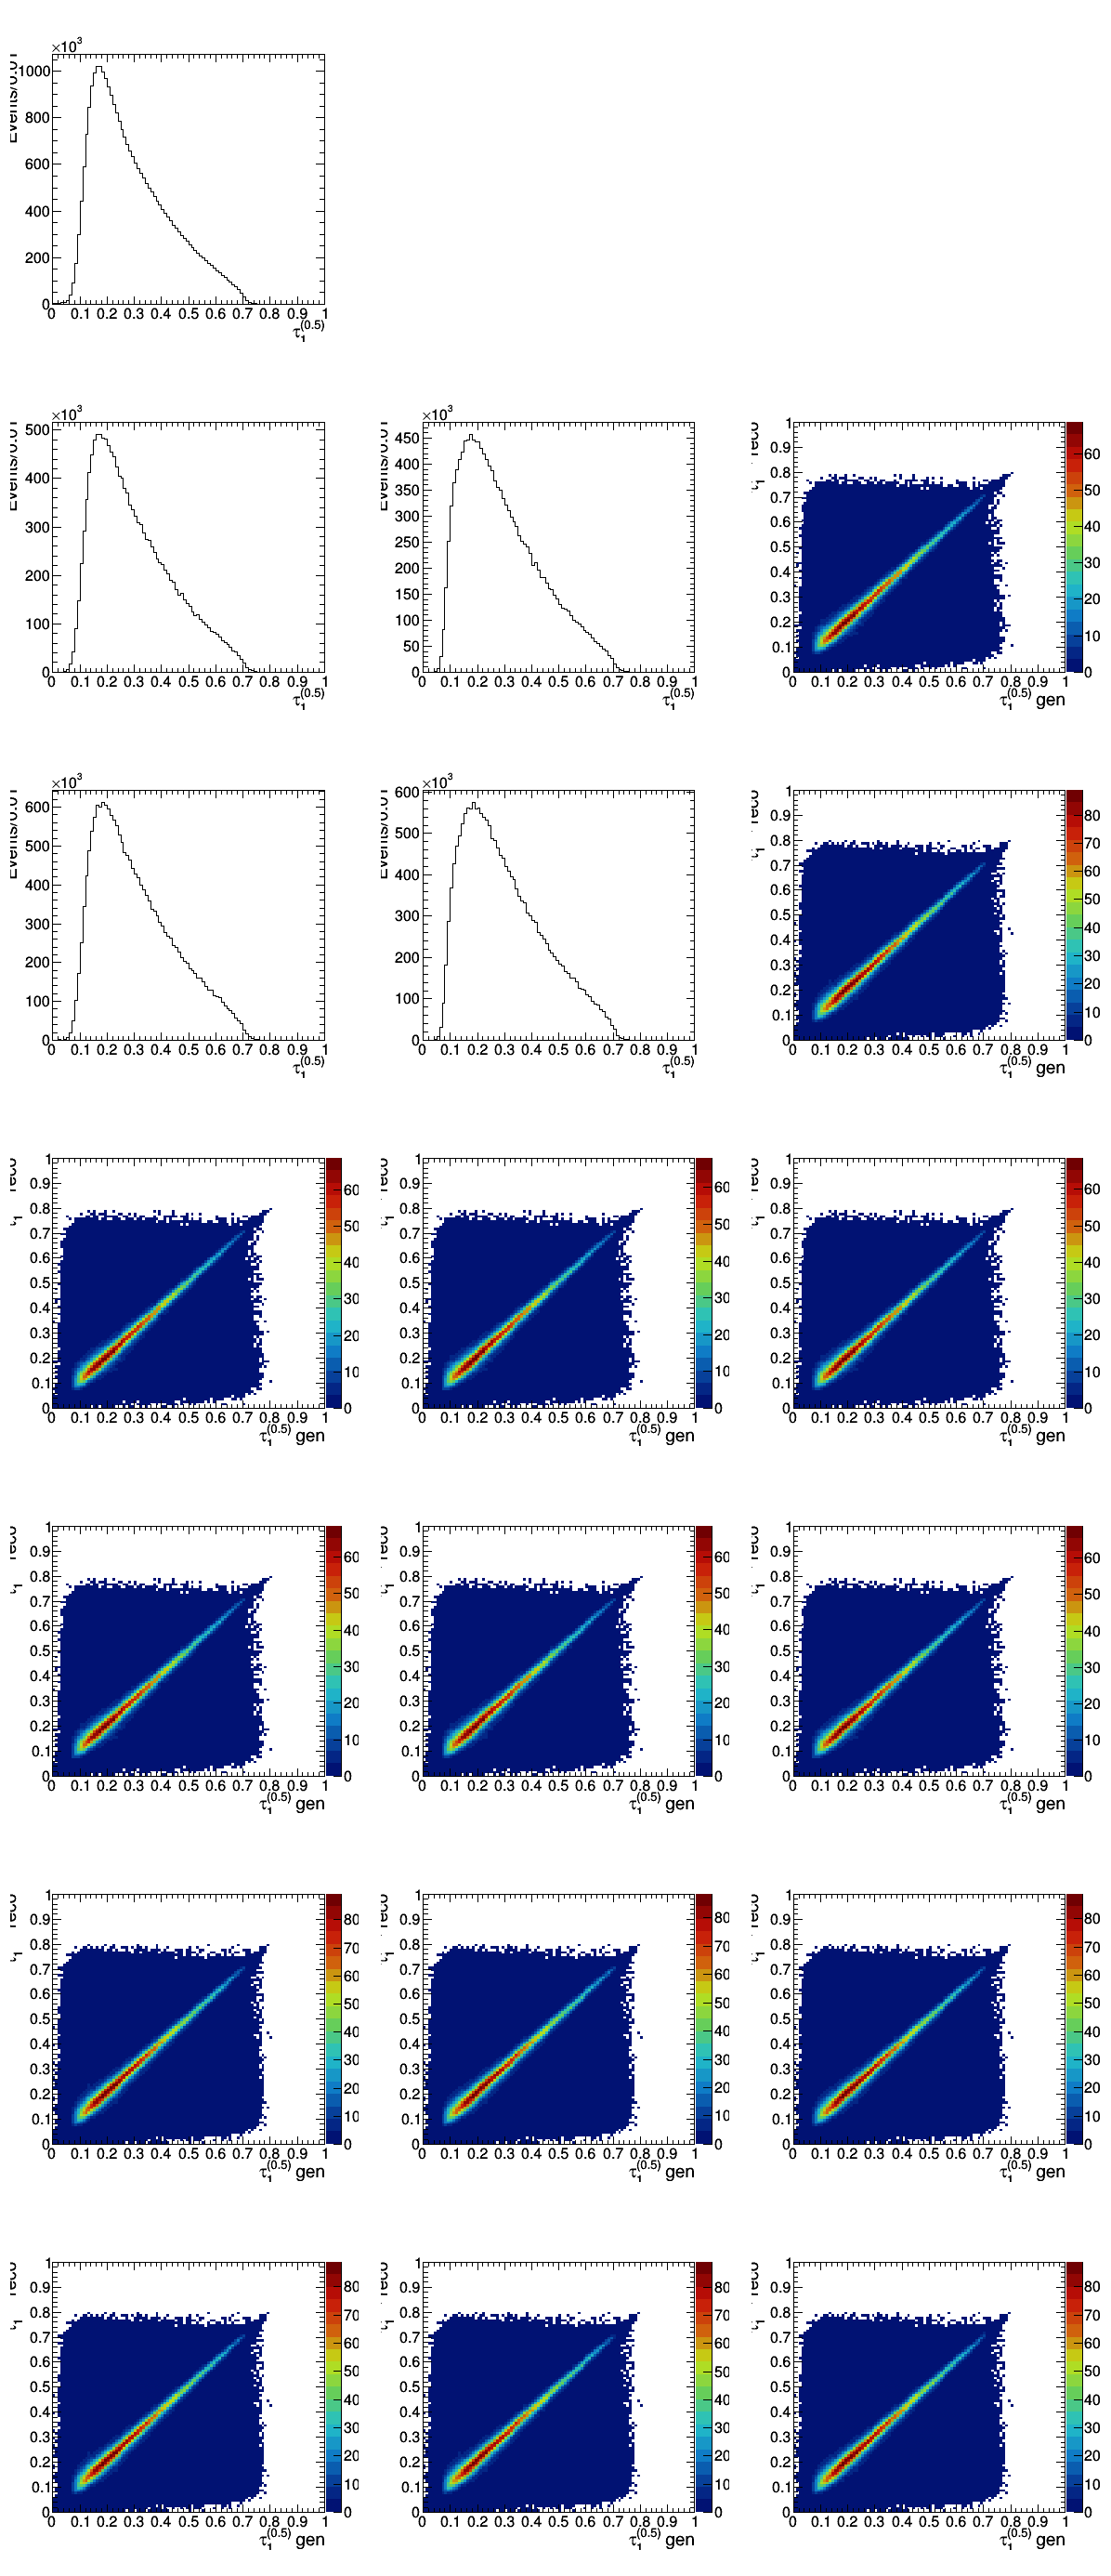

In [8]:
var='tau_0p5_0'
c0=rt.TCanvas("c0","c0",0,0,1200,2800)
c0.Divide(3,7)
c0.cd(1)
Data_0[reco[var]].Draw("hist")
c0.cd(4)
MC1_0[reco[var]].Draw("hist")
c0.cd(5)
MC1_0[gen[var]].Draw("hist")
c0.cd(6)
MC1_0[resp[var]].Draw("Colz")
c0.cd(7)
MC2_0[reco[var]].Draw("hist")
c0.cd(8)
MC2_0[gen[var]].Draw("hist")
c0.cd(9)
MC2_0[resp[var]].Draw("Colz")
c0.Draw()
i=10
for source in ['jesTotal',"jer","pu"]:
    for ud in ['Up','Down']:
        c0.cd(i)
        MC1_0[sysunc[var+source+ud]].Draw("Colz")
        i+=1
for source in ['jesTotal',"jer","pu"]:
    for ud in ['Up','Down']:
        c0.cd(i)
        MC2_0[sysunc[var+source+ud]].Draw("Colz")
        i+=1

In [9]:
gen_bins={}
reco_bins={}
gen_bins[variables[0]]=np.array([0.0,0.12,0.18,0.24,0.3,0.36,0.42,0.48,0.54,0.6,0.66,0.72,0.81])
reco_bins[variables[0]]=np.array([0.0,0.06,0.12,0.15,0.18,0.21,0.24,0.27,0.3,0.33,0.36,0.39,0.42,0.45,0.48,0.51,0.54,0.57,0.6,0.63,0.66,0.69,0.72,0.76,0.81])
gen_bins[variables[1]]=np.array([0.0,0.04,0.08,0.12,0.16,0.2,0.24,0.28,0.32,0.36,0.4,0.44,0.48,0.66])
reco_bins[variables[1]]=np.array([0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3,0.32,0.34,0.36,0.38,0.4,0.42,0.44,0.46,0.48,0.57,0.66])
gen_bins[variables[2]]=np.array([0.0,0.04,0.08,0.12,0.16,0.2,0.24,0.28,0.46])
reco_bins[variables[2]]=np.array([0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.36,0.46])
gen_bins[variables[3]]=np.array([0.0,0.08,0.14,0.2,0.26,0.32,0.38,0.44,0.5,0.56,0.68])
reco_bins[variables[3]]=np.array([0.0,0.04,0.08,0.11,0.14,0.17,0.2,0.23,0.26,0.29,0.32,0.35,0.38,0.41,0.44,0.47,0.5,0.53,0.56,0.62,0.68])
gen_bins[variables[4]]=np.array([0.0,0.04,0.08,0.12,0.16,0.2,0.24,0.28,0.47])
reco_bins[variables[4]]=np.array([0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.37,0.47])
gen_bins[variables[5]]=np.array([0.0,0.02,0.04,0.06,0.08,0.12,0.24])
reco_bins[variables[5]]=np.array([0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.1,0.12,0.18,0.24])
gen_bins[variables[6]]=np.array([0.0,0.06,0.12,0.18,0.24,0.3,0.36,0.56])
reco_bins[variables[6]]=np.array([0.0,0.03,0.06,0.09,0.12,0.15,0.18,0.21,0.24,0.27,0.3,0.33,0.36,0.47,0.56])
gen_bins[variables[7]]=np.array([0.0,0.04,0.08,0.12,0.16,0.2,0.32])
reco_bins[variables[7]]=np.array([0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.26,0.32])
gen_bins[variables[8]]=np.array([0.0,0.02,0.04,0.06,0.14])
reco_bins[variables[8]]=np.array([0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.1,0.14])
gen_bins[variables[9]]=np.array([0.0,0.06,0.12,0.18,0.24,0.3,0.36,0.49])
reco_bins[variables[9]]=np.array([0.0,0.03,0.06,0.09,0.12,0.15,0.18,0.21,0.24,0.27,0.3,0.33,0.36,0.42,0.49])
gen_bins[variables[10]]=np.array([0.0,0.02,0.04,0.06,0.1,0.14,0.18,0.26])
reco_bins[variables[10]]=np.array([0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.19,0.26])
gen_bins[variables[11]]=np.array([0.0,0.02,0.04,0.09])
reco_bins[variables[11]]=np.array([0.0,0.01,0.02,0.03,0.04,0.06,0.09])
#gen_bins[variables[9]]=np.array([0.0,0.04,0.08,0.12,0.16,0.2,0.24,0.28,0.41])
#reco_bins[variables[9]]=np.array([0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.32,0.41])
#gen_bins[variables[10]]=np.array([0.0,0.02,0.04,0.08,0.12,0.23])
#reco_bins[variables[10]]=np.array([0.0,0.01,0.02,0.03,0.04,0.06,0.08,0.1,0.12,0.16,0.23])
#gen_bins[variables[11]]=np.array([0.0,0.02,0.1])
#reco_bins[variables[11]]=np.array([0.0,0.01,0.02,0.05,0.1])
for i in range(12):
    print gen_bins[variables[i]],gen_bins[variables[i]].shape[0]-1
    print reco_bins[variables[i]],reco_bins[variables[i]].shape[0]-1

[0.   0.12 0.18 0.24 0.3  0.36 0.42 0.48 0.54 0.6  0.66 0.72 0.81] 12
[0.   0.06 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.33 0.36 0.39 0.42 0.45
 0.48 0.51 0.54 0.57 0.6  0.63 0.66 0.69 0.72 0.76 0.81] 24
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.66] 13
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.57 0.66] 26
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.46] 8
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.36 0.46] 16
[0.   0.08 0.14 0.2  0.26 0.32 0.38 0.44 0.5  0.56 0.68] 10
[0.   0.04 0.08 0.11 0.14 0.17 0.2  0.23 0.26 0.29 0.32 0.35 0.38 0.41
 0.44 0.47 0.5  0.53 0.56 0.62 0.68] 20
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.47] 8
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.37 0.47] 16
[0.   0.02 0.04 0.06 0.08 0.12 0.24] 6
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.1  0.12 0.18 0.24] 12
[0.   0.06 0.12 0.18 0.

In [24]:
Data={}
#MC1={}
MC2={}
Sysunc2={}
Can={}
CanUnc={}
for var in variables:
    print var
    gen_bin=gen_bins[var]
    reco_bin=reco_bins[var]
    Data[reco[var]]=rt.TH1D("Data_reco: "+title[var],"Data_reco: "+title[var]+';'+title[var]+';Events',reco_bin.shape[0]-1,reco_bin)
    #MC1[reco[var]]=rt.TH1D("MC1_reco:"+title[var],"MC1_reco:"+title[var]+';'+title[var]+';Events',reco_bin.shape[0]-1,reco_bin)
    #MC1[gen[var]]=rt.TH1D("MC1_gen:"+title[var],"MC1_gen:"+title[var]+';'+title[var]+';Events',gen_bin.shape[0]-1,gen_bin)
    #MC1[resp[var]]=rt.TH2D("Response1:"+title[var],"Response1:"+title[var]+';'+title[var]+' gen;'+title[var]+' reco',gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    MC2[reco[var]]=rt.TH1D("MC2_reco: "+title[var],"MC2_reco: "+title[var]+';'+title[var]+';Events',reco_bin.shape[0]-1,reco_bin)
    MC2[gen[var]]=rt.TH1D("MC2_gen: "+title[var],"MC2_gen: "+title[var]+';'+title[var]+';Events',gen_bin.shape[0]-1,gen_bin)
    MC2[resp[var]]=rt.TH2D("Response2: "+title[var],"Response2: "+title[var]+';'+title[var]+' gen;'+title[var]+' reco',gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    Sysunc2[var]={}
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            #MC1_0[sysunc[var+source+ud]]=rt.TH2D('Unc1_0_'+title[var]+':'+source+ud,'Unc1_0_'+title[var]+':'+source+ud+';'+title[var]+' gen;'+title[var]+' reco',gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
            Sysunc2[var][source+ud]=rt.TH2D('Unc2_'+title[var]+': '+source+ud,'Unc2_'+title[var]+': '+source+ud+';'+title[var]+' gen;'+title[var]+' reco',gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_0[reco[var]],Data[reco[var]],reco_bin)
    Fill1D(MC2_0[reco[var]],MC2[reco[var]],reco_bin)
    Fill1D(MC2_0[gen[var]],MC2[gen[var]],gen_bin)
    Fill2D(MC2_0[resp[var]],MC2[resp[var]],gen_bin,reco_bin)
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            Fill2D(MC2_0[sysunc[var+source+ud]],Sysunc2[var][source+ud],gen_bin,reco_bin)
    
    MC2[resp[var]].SetStats(0)
    
    Data[reco[var]].Scale(1./Data[reco[var]].Integral())
    MC2[reco[var]].Scale(1./MC2[reco[var]].Integral())
    MC2[gen[var]].Scale(1./MC2[gen[var]].Integral())
    
    Can[var],CanUnc[var]=DoUnfolding(MC2[resp[var]],Data[reco[var]],MC2[reco[var]],MC2[gen[var]],Sysunc2[var],title[var])

tau_0p5_0
yes
tau_1_0
tau_2_0
yes
tau_0p5_1
tau_1_1
tau_2_1
tau_0p5_2
tau_1_2
tau_2_2
tau_0p5_3
tau_1_3
tau_2_3


Warning in <TROOT::Append>: Replacing existing TH1: Data_reco: #tau_{1}^{(0.5)} (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_reco: #tau_{1}^{(0.5)} (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 24 input bins and 12 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{1}^{(0.5)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #13 (xaxis:#tau_{1}^{(0.5)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Warning in <TROOT::Append>: Replacing existing TH1: Data_unfolded_TotalUnc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Data_folded (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Total Covariance Matrix (Potential memory leak).
Warn

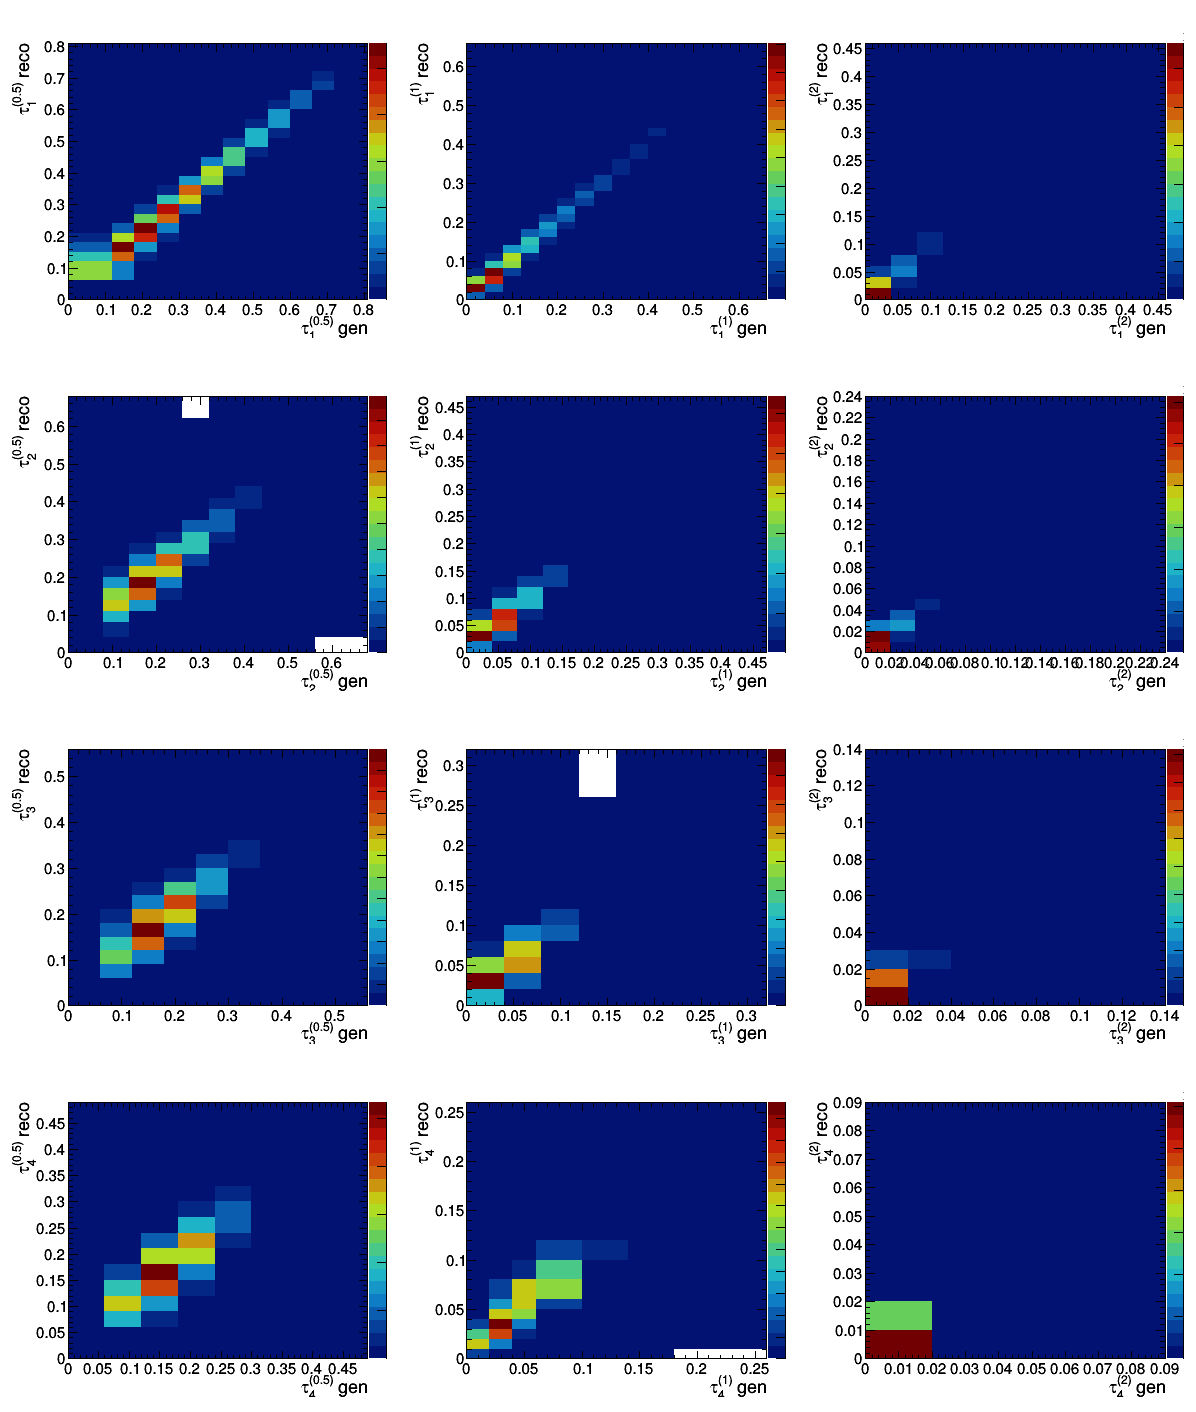

In [11]:
c=rt.TCanvas("Response","Response",0,0,1200,1440)
c.Divide(3,4)
i=1
for var in variables:
    c.cd(i)
    MC2[resp[var]].Draw("Colz")
    i+=1
c.Draw()